<font size=7> Latencies Analysis

In [12]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, plot_latency_dist_hist, plot_latency_angle_hist, \
                                 plot_cross_sttc_pairs, plot_vector_layout2, plot_vector_layout3
from human_hip.animate import animate_latencies

In [13]:
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, cross_sttc, plot_pair_analysis, plot_cross_sttc_pairs
import pickle
import matplotlib.pyplot as plt
from ipywidgets import interact_manual
import numpy as np
import pickle

In [14]:
with open("/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/curated_base_acqm.pkl", "rb") as filename:
    sd = pickle.load(filename)

In [15]:
import numpy as np
from human_hip.spike_data import latencies, cross_sttc

def curate_latencies(sd, cross_sttc_min_cutoff=2, cross_sttc_max_cutoff=30, sttc_cutoff = 0.04, latency_cutoff=2.5, sttc_delta=20 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  #latency= np.median(pair_latencies)
        if abs(np.mean(pair_latencies))> latency_cutoff and len(pair_latencies)>25:
        #if stats.ttest_1samp(pair_latencies,0)[1]<.1 and len(pair_latencies)>25:
            #pairs_late.append( pair )  #lags_late.append( latency )
            if np.mean(pair_latencies) < 0:
                pair_latencies = latencies( pair[1], pair[0], sd, ms_cutoff_high=cross_sttc_max_cutoff) 
                if np.mean(pair_latencies)> latency_cutoff and len(pair_latencies)>25:
                    #print("original pair: ", pair)
                    #print("added pair: ", [ pair[1], pair[0] ])
                    pairs_late.append( [ pair[1], pair[0] ] )   #lags_late.append( latency )
            else:
                pairs_late.append( pair ) 
    pairs_late
    print( len(pairs_late), "pairs above latencency cutoff")

    # print("Checking all latencies are positive")
    # mean_latencies = []
    # for pair in pairs_late:
    #     mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  )
    #     mean_latencies.append(mean_latency)
    # print("All positvie?: ",np.all( np.array(mean_latencies)>0 ) )

    ##Do cross sttc for all pairs
    print("Starting cross_sttc calculation... might take a minute")
    cross_lag  = [] 
    for pair in pairs_late: 
        sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
        max_args = np.argwhere(sttcs == np.amax(sttcs)) - 1000 
        cross_lag.append( max_args[np.argmin(np.abs(max_args))][0] )   # if multiple maxima, take the one closest to zero
    cross_lag = np.array(cross_lag)
    to_keep = np.where(( cross_lag< cross_sttc_max_cutoff) & (cross_lag> cross_sttc_min_cutoff) & (cross_lag!=0) )[0]
    print( len(to_keep), "pairs between cross_sttc cutoffs")

    pairs_final = []
    for i in to_keep:
        pairs_final.append(pairs_late[i])

    pairs_final = []
    for i in to_keep:
        pairs_final.append(pairs_late[i])
    
    mean_latencies = []
    for pair in pairs_final:
        mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=cross_sttc_max_cutoff)  )
        mean_latencies.append(mean_latency)
    print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))
    #good_pairs =   np.array(pairs_final)

    return  pairs_final



In [16]:
good_pairs = curate_latencies(sd)

62001 Starting Pairs
1364 pairs above sttc cutoff
143 pairs above latencency cutoff
Starting cross_sttc calculation... might take a minute
54 pairs between cross_sttc cutoffs
all final pairs positive?: True


In [17]:
mean_latencies = []
for pair in good_pairs:
    mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=30)  )
    mean_latencies.append(mean_latency)
print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))
#good_pairs =   np.array(pairs_final)

all final pairs positive?: True


In [18]:
good_pairs2 = np.array(good_pairs)

In [19]:
mean_latencies = []
for pair in good_pairs2:
    mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=30)  )
    mean_latencies.append(mean_latency)
print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))
#good_pairs =   np.array(pairs_final)

all final pairs positive?: True


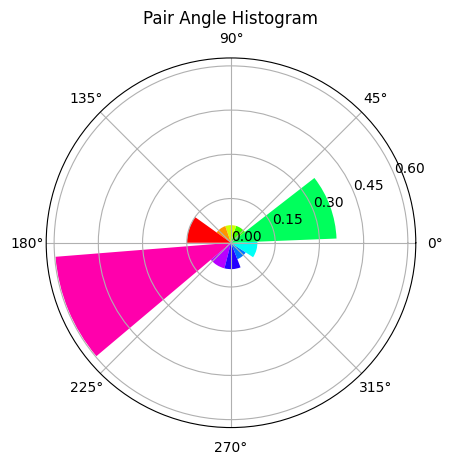

In [20]:
plot_latency_angle_hist(sd, good_pairs2,  by_firing_rate=False, late_cutoff_high=30)

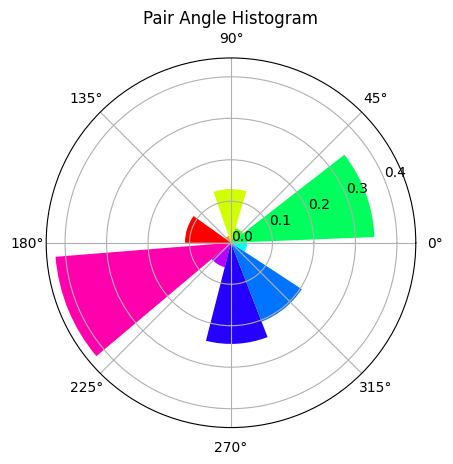

In [21]:
plot_latency_angle_hist(sd, good_pairs2,  by_firing_rate=True, late_cutoff_high=30)

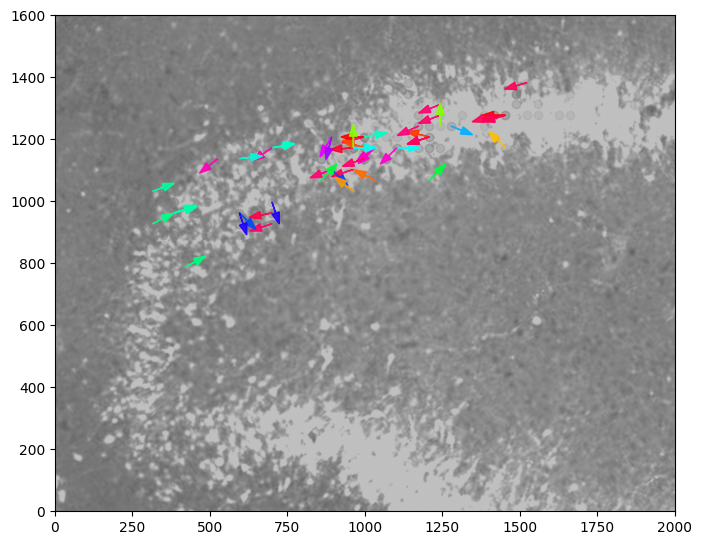

In [22]:
plot_vector_layout( sd, good_pairs2,  image_path="/workspaces/human_hippocampus/data/histology/hc112823_bw_old.png",
                     xlim=(0,2000), ylim=(0,1600) )

In [23]:
from ipywidgets import interact_manual, interact
from scipy import stats

def pairs_hisogram(good_pairs2, sd, ms_cutoff_high=30):
    @interact
    def plot_pair(pair_i = (0, len(good_pairs)-1) ):
        latencies_pair = latencies( good_pairs[pair_i][0], good_pairs[pair_i][1], sd, ms_cutoff_high=ms_cutoff_high )
        plt.xlim(-ms_cutoff_high, ms_cutoff_high)
        plt.hist(latencies_pair, bins=12)
        print("Pair: ", good_pairs[pair_i][0],good_pairs[pair_i][1] )
        print("Latency Mean:\t", np.mean(latencies_pair ) )

        t_stat, p_value = stats.ttest_1samp( latencies_pair, 0)
        one_sided_p_value = p_value / 2 if t_stat > 0 else 1 - p_value / 2
        print("T-Test 1-Side:\t", one_sided_p_value )  #print("T-Test: ", stats.ttest_1samp(latencies_pair, 0)[1] )
        
pairs_hisogram( good_pairs2, sd, ms_cutoff_high=30)

interactive(children=(IntSlider(value=26, description='pair_i', max=53), Output()), _dom_classes=('widget-inte…